## Experiment 4: Ensembles and Adaptive-Metric-Softmax (AMS)

This notebook systematically compares selected *singular* XAI methods and *ensemble* approaches (along with custom extension).

**Singular XAI Methods**
- Vanilla Gradients (Saliency)
- Integrated Gradients (IG)
- GradientSHAP
- GuidedGradCam

**Ensembles**
- NormEnsembleXAI
- AutoWeighted (as baseline)
- AMS (Adaptive-Metric Softmax)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc
import torch
import torchvision

import quantus
import functools

c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl # for pdf export
mpl.rcParams['pdf.fonttype'] = 42; mpl.rcParams['ps.fonttype']  = 42

# free Python objects
gc.collect()
# free all unused cached memory in PyTorch’s CUDA allocator
torch.cuda.empty_cache()

# Reproducibility
torch.manual_seed(0); np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load `ImageNet` samples
This subset of ImageNet contains:
  - `x_batch` ... images
  - `y_batch` ... labels
  - `s_batch` ... segmentation masks (required by Localization metrics)

In [5]:
# Load data
x_batch = torch.load("imagenet50-samples/x_batch.pt").to(device)
y_batch = torch.load("imagenet50-samples/y_batch.pt").to(device)
s_batch = torch.load("imagenet50-samples/s_batch.pt").to(device)

num_samples = len(x_batch)
print(f"{num_samples} matches found.")

500 matches found.


In [6]:
class_to_index = torch.load("imagenet50-samples/class_to_index.pt")
with open('imagenet50-samples/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f]
# Create reverse mapping (class indx : class label)
index_to_label = dict(enumerate(labels)) # {0: 'tench', 1: 'goldfish', ...}

### Select working subset of ImageNet
- used for both qualitative and quantitative analyses

> **Beware:** too large subset size may be computationally heavy for quant. metric calculation

In [7]:
SUBSET_SIZE = 30

torch.manual_seed(777) # 349
indices = torch.randperm(num_samples)[:SUBSET_SIZE]

x_batch = x_batch[indices].to(device) # (30, 3, 224, 224)
y_batch = y_batch[indices].to(device) # (30,)
s_batch = s_batch[indices].to(device) # (30, 1, 224, 224)
s_batch.shape

torch.Size([30, 1, 224, 224])

### Pre-trained `ResNet50`

In [8]:
model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
).to(device)

model.eval();

## Compute individual XAI explanations

In [9]:
def explain_in_chunks(method, x, y, chunk=4, **kwargs):
    """Compute explanations in batches to manage memory usage when applying XAI methods."""
    out = []
    x = x.clone().detach().requires_grad_(True)
    for i in range(0, len(x), chunk):
        attr = quantus.explain(
            model,
            x[i:i+chunk],
            y[i:i+chunk],
            method=method,
            n_steps=32,            # keep path resolution
            internal_batch_size=1, # shard interpolation steps
            device=device,
            **kwargs
        )
        
        out.append(attr) # move result off-GPU
        torch.cuda.empty_cache()
    return np.concatenate([x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in out])

In [10]:
# NOTE: quantus.helpers.constants.AVAILABLE_XAI_METHODS_CAPTUM # list available captum XAI methods

In [11]:
# ResNet layer - requirement for Guided Grad-CAM method
target_layer = model.layer4[-1].conv3
layer_kw = {"gc_layer": target_layer}

explanations = {
    "Gradient":            explain_in_chunks("Gradient", x_batch, y_batch, chunk=16),
    "IntegratedGradients": explain_in_chunks("IntegratedGradients", x_batch, y_batch, chunk=2),
    "GradientShap":        explain_in_chunks("GradientShap", x_batch, y_batch, chunk=2),
    "GuidedGradCam":       explain_in_chunks("GuidedGradCam", x_batch, y_batch, chunk=2, **layer_kw),
    # NOTE: other XAI methods can be added an analyzed along
    # "LayerGradCam": explain_in_chunks(
    #     "LayerGradCam",
    #     x_batch,
    #     y_batch,
    #     chunk=2,
    #     interpolate=x_batch.shape[2:],   # (224, 224) – match input
    #     interpolate_method="nearest",   # or "bilinear"
    #     **layer_kw,
    # ),
}


c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


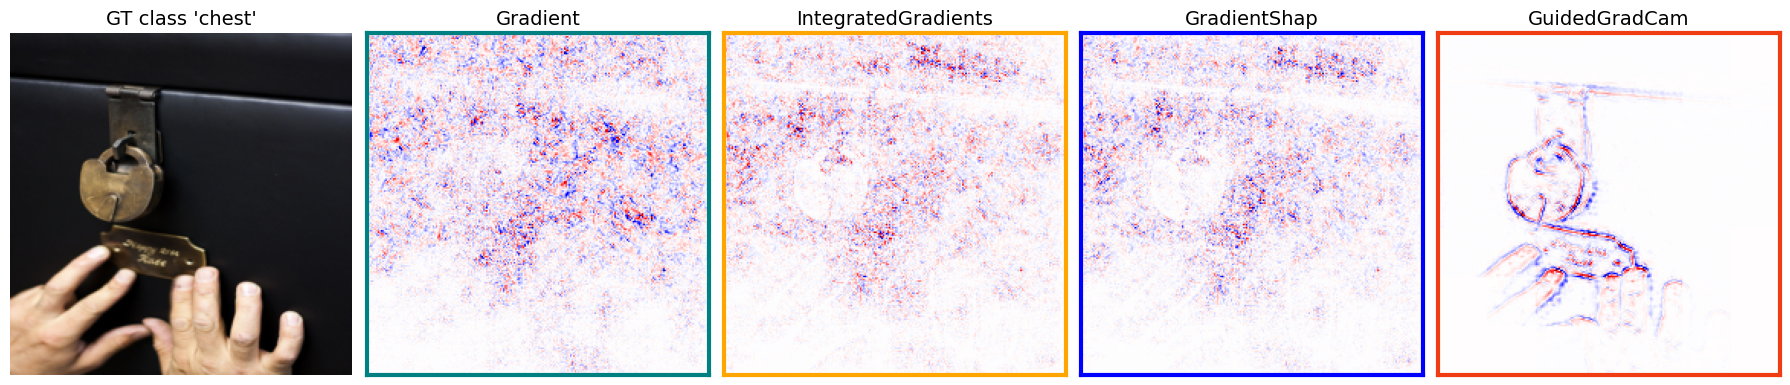

In [12]:
COLOR_FRAME   = ["#008080" , "#FFA500"            , "#0000FF"     , "#f03c13"]
DISPLAY_ORDER = ["Gradient", "IntegratedGradients", "GradientShap", "GuidedGradCam"]

idx = 0 # single sample to display

ncols = 1 + len(DISPLAY_ORDER)
fig, axes = plt.subplots(1, ncols, figsize=(18, 3 * ncols))

# Original image
denorm = quantus.normalise_func.denormalise(
    x_batch[idx].cpu().numpy(),
    mean=np.array([0.485, 0.456, 0.406]),
    std=np.array([0.229, 0.224, 0.225]),
)
denorm = np.clip(denorm, 0.0, 1.0)
axes[0].imshow(np.moveaxis(denorm, 0, -1))
axes[0].set_title(f"GT class '{index_to_label[y_batch[idx].item()]}'", fontsize=14) 
axes[0].axis("off")

# Explanation maps
for col, method in enumerate(DISPLAY_ORDER, start=1):
    heat = quantus.normalise_func.normalise_by_negative(
        explanations[method][idx].reshape(224, 224)
    )
    axes[col].imshow(heat, cmap="seismic", vmin=-1, vmax=1)
    axes[col].set_title(method, fontsize=14)
    axes[col].set_xticks([]); axes[col].set_yticks([])
        
    # Frame styling with colored borders
    axes[col].grid(False)
    for spine in axes[col].spines.values():
        spine.set_color(COLOR_FRAME[col - 1])
        spine.set_linewidth(3)

plt.tight_layout()
#plt.savefig('figures/ex4-ensembles-qualitative.pdf', bbox_inches="tight")
plt.show()

---

## Compute Ensemble Attributions

In [13]:
# Keep track of weights for AW and AMS
ensemble_weights = {} 

### NormEnsembleXAI ([Hryniewska-Guzik et al., 2024](https://arxiv.org/abs/2401.17200))
- normalize + aggregate (*mean*)

In [14]:
# ----------------------------------------------------------------
# NormEnsembleXAI  (global z-score -> mean)
# ----------------------------------------------------------------
BASE_METHODS = ["Gradient", "IntegratedGradients", "GradientShap", "GuidedGradCam"]

base_tensors = torch.stack(
    [torch.from_numpy(explanations[m]).to(device) for m in BASE_METHODS],
    dim=1)                              # (N, M, C, H, W)

# Global z-score normalisation
var, mean = torch.var_mean(base_tensors, dim=(0, 2, 3, 4), unbiased=True, keepdim=True)

# Normalise each attribution map
normed_maps = (base_tensors - mean) / torch.sqrt(var + 1e-8)

# Using the 'mean' for aggregation
norm_ensemble = normed_maps.mean(dim=1) # (N, C, H, W)

explanations["NormEnsembleXAI"] = norm_ensemble.cpu().numpy()

del base_tensors, normed_maps, norm_ensemble
torch.cuda.empty_cache()

---

### Prepare for AutoWeighted and AMS Ensemble methods
- requirement of quantitative metric calculation in order to obtain weights
- see Master's Thesis text for specific methodology of each ensemble approach

In [15]:
# ----------------------------------------------------------------
# Gather base attribution maps
# ----------------------------------------------------------------
#BASE_METHODS = ["Gradient", "IntegratedGradients", "GradientShap", "GuidedGradCam"]

attrib_maps = torch.stack(
    [torch.from_numpy(explanations[m]).to(device) for m in BASE_METHODS],
    dim=1,                           # (N, M, C, H, W)
)
num_samples, num_methods, C_attr, H_attr, W_attr = attrib_maps.shape

In [16]:
# ----------------------------------------------------------------
# Dataset-wide normalisation of attribution maps
# ----------------------------------------------------------------
var_all, mean_all = torch.var_mean(
    attrib_maps, dim=(0, 2, 3, 4), unbiased=False, keepdim=True
)
attrib_maps_norm = (attrib_maps - mean_all) / torch.sqrt(var_all + 1e-8)

In [17]:
# ----------------------------------------------------------------
# Quantitative metrics
# ----------------------------------------------------------------
metrics = [
    # ↑ complexity – higher is better
    quantus.Sparseness(abs=True, normalise=True,  return_aggregate=False),

    # ↓ faithfulness – lower is better
    quantus.PixelFlipping(features_in_step=1024,
                          abs=True, normalise=True,
                          perturb_baseline='mean',
                          return_aggregate=False),
    # ↓ robustness – lower is better
    quantus.LocalLipschitzEstimate(nr_samples=5,
                                   perturb_std=0.2,
                                   return_aggregate=False),
    # ↑ localization - higher is better
    quantus.RelevanceMassAccuracy(abs=True, normalise=False,
                                  return_aggregate=False), 
]

In [18]:
# Manual weights setting
metric_weights = torch.tensor([0.35, 0.25, 0.25, 0.15], device=device)
# Specify metric direction
higher_is_better = torch.tensor([True, False, False, True], device=device)

In [19]:
# ----------------------------------------------------------------
# HELPERS
# ----------------------------------------------------------------
def _collapse_to_scalar(vec):
    """helper: squeeze any per-step curve to a scalar per attribution."""
    arr = np.asarray(vec)
    return arr.mean(axis=-1) if arr.ndim > 1 else arr

def _gradient_explainer(model, inputs, targets=None, **kwargs):
    # Guarantee Captum gets int64 – return a Python-list, not a Tensor
    if isinstance(inputs, np.ndarray):
        inputs_t = torch.from_numpy(inputs).float().to(device)
    else:
        inputs_t = inputs.to(device)
    # Ensure inputs are differentiable
    inputs_t = inputs_t.clone().detach().requires_grad_(True)
    if targets is None:
        targets = model(inputs_t).argmax(dim=1).cpu().numpy()

    # make sure to hold plain integers
    if isinstance(targets, np.ndarray):
        targets_idx = targets.astype(np.int64).tolist()
    elif torch.is_tensor(targets):
        targets_idx = targets.long().cpu().tolist()
    else: # e.g. list or scalar
        targets_idx = [int(t) for t in np.atleast_1d(targets)]

    return quantus.explain(
        model, inputs_t, targets_idx, method="Gradient", device=device
    )

In [20]:
# ---------------------------------------------------------------
# Metric evaluation with bootstrapping
# ---------------------------------------------------------------
B = 1  # NOTE: Bootstrapping is design choice of AMS
flat_attr  = attrib_maps.reshape(num_samples*num_methods, C_attr, H_attr, W_attr)

repeat_x   = x_batch.repeat_interleave(num_methods, 0)
repeat_y   = y_batch.repeat_interleave(num_methods, 0)
repeat_s   = s_batch.repeat_interleave(num_methods, 0)

# Bootstrap scores is (B, N*M, K) tensor
bootstrap_scores = torch.empty((B, repeat_x.size(0), len(metrics)), device=device)

for b in range(B):
    run_scores = []
    for metric in metrics:
        print(f"Metric '{metric}' ...")
        raw_scores = metric(
            model        = model,
            x_batch      = repeat_x.cpu().numpy(),
            y_batch      = repeat_y.cpu().numpy(),
            a_batch      = flat_attr.cpu().numpy(),
            s_batch      = repeat_s.cpu().numpy(),
            device       = device,
            explain_func = _gradient_explainer,
        )

        score_vec = torch.as_tensor(_collapse_to_scalar(raw_scores), device=device)
        run_scores.append(score_vec)

    bootstrap_scores[b] = torch.stack(run_scores, dim=-1)

metric_scores_mean = bootstrap_scores.mean(0).view(num_samples, num_methods, -1)
metric_scores_std  = bootstrap_scores.std(0, unbiased=False).view(num_samples, num_methods, -1)

torch.cuda.empty_cache()

Metric '<quantus.metrics.complexity.sparseness.Sparseness object at 0x000002A3039C3C10>' ...
Metric '<quantus.metrics.faithfulness.pixel_flipping.PixelFlipping object at 0x000002A375FBF910>' ...
Metric '<quantus.metrics.robustness.local_lipschitz_estimate.LocalLipschitzEstimate object at 0x000002A375FBFEE0>' ...
Metric '<quantus.metrics.localisation.relevance_mass_accuracy.RelevanceMassAccuracy object at 0x000002A375FBF820>' ...


In [21]:
# ----------------------------------------------------------------
# Direction correction and z-score normalisation
# ----------------------------------------------------------------
sign_tensor = torch.where(higher_is_better, 1.0, -1.0).to(device)  # (K,)
directed_scores = metric_scores_mean * sign_tensor                 # maximize all

sample_mean = directed_scores.mean(dim=1, keepdim=True)
sample_std  = directed_scores.std (dim=1, keepdim=True, unbiased=False) + 1e-8
z_scores = (directed_scores - sample_mean) / sample_std            # (N, M, K)

---

### [AutoWeighted](https://www.iccs-meeting.org/archive/iccs2021/papers/127450037.pdf) Ensemble
- global, image-independent weights

In [22]:
# AutoWeighted ensemble  —  baseline from Bobek et al. (2021)
# ===============================================================
# Re-use
#   attrib_maps_norm   (N, M, C, H, W)   <- globally z-scored maps
#   directed_scores    (N, M, K)         <- sign-corrected raw metric values
#   metric_weights     (K,)              <- λ-vector
# --------------------------------------------------------------

# 1) collapse the sample axis ->  one quality vector per method
# ---> AutoWeighted is defined as a *global* weighting scheme
global_scores   = directed_scores.mean(dim=0)                   # (M, K)
quality_scores  = (global_scores * metric_weights).sum(-1)      # (M,)

# 2) softmax-style normalization (but only once – no per-image loop)
quality_scores  = quality_scores.clamp(min=1e-8)                # avoid div/0
weights_aw_vec  = quality_scores / quality_scores.sum()         # (M,)

# 3) broadcast the same 4 numbers to every sample
weights_aw = (
    weights_aw_vec.view(1, num_methods, 1, 1, 1)
    .expand(num_samples, -1, 1, 1, 1)                           # (N, M, 1, 1, 1)
)

# Store weights for later inspection
ensemble_weights["AutoWeighted"] = (
    weights_aw.squeeze(-1).squeeze(-1).squeeze(-1).cpu().numpy()  # shape (N, M)
)

# 4) weighted sum of the normalised maps
autoweighted_maps = (weights_aw * attrib_maps_norm).sum(dim=1)   # (N, C, H, W)
explanations["AutoWeighted"] = autoweighted_maps.cpu().numpy()

print("AutoWeighted maps:", explanations["AutoWeighted"].shape)

AutoWeighted maps: (30, 1, 224, 224)


---

## Adaptive-Metric Softmax (AMS)

Let $i$ be the current input sample of interest, then:

0. Compute $E$ **attributions** for the input
    - $\phi_e^{(i)}$
1. Compute $K$ **metrics** (for each attrib $e$ and each metric $k$)
    - $m_{e, k}^{(i)}$
    - allow users trade-offs and priorities ($\lambda$)
    - input ($i$) $\to$ $E$ attributions $\to$ each $e\in E$ results in $k$ metrics
2. z-score **normalize** (per-metric, across methods): 
    - $\hat{m}_{e,k}^{(i)}$
3. Compute **utility score** (metrics aggregated to 1 quality score per method)
    - $s_e^{(i)} = \sum^k \lambda_k \hat{m}_{e,k}^{(i)}$
    - "uncertainty aware" - stability of metric evals
4. **Confidence correction** 
    - $c_e^{(i)}$
5. Compute **weights** via *softmax* 
    - $w_e^{(i)}$
6. **Fusion** 
    - $\phi_{AMS}^{(i)} = \sum^E w_e^{(i)} \cdot \phi_e^{(i)}$ 

> NOTE: Steps 0-2 already computed (partially shared results with AutoWeighted) 

In [23]:
# ----------------------------------------------------------------
# NOTE: experimental
# 5.x  Diversity penalty  (1 – mean |cosine| similarity)
# ----------------------------------------------------------------
flat_norm = attrib_maps_norm.view(num_samples, num_methods, -1)     # (N,M,P)
# L2-normalize so dot-product = cosine similarity
flat_norm = torch.nn.functional.normalize(flat_norm, dim=-1)

# cosine similarity matrix per image: (N,M,M)
cos_mat = torch.einsum('nmp,nkp->nmk', flat_norm, flat_norm).abs()
# exclude self-similarity on the diagonal
eye = torch.eye(num_methods, device=device).unsqueeze(0)
mean_sim = (cos_mat * (1 - eye)).sum(-1) / (num_methods - 1)        # (N,M)
diversity_factor = 1.0 - mean_sim                                   # (N,M)


In [24]:
# ----------------------------------------------------------------
# Utility and confidence
# ----------------------------------------------------------------
#utilities = (z_scores * metric_weights).sum(dim=-1)                # (N, M)
# NOTE: experimental
utilities = (z_scores * metric_weights).sum(dim=-1) #TODO: * diversity_factor

conf_sigma = (metric_scores_std * metric_weights).pow(2).sum(dim=-1).sqrt()
confidence = torch.exp(-conf_sigma)                                # (N, M)

In [25]:
# Softmax weights
# ----------------------------------------------------------------
temperature = 1.0
logits   = temperature * utilities * confidence
weights  = torch.softmax(logits, dim=1).view(num_samples, num_methods, 1, 1, 1)

# Store weights for later inspection: shape (N, 4, 1, 1, 1)
ensemble_weights["AMS"] = (
    weights.squeeze(-1).squeeze(-1).squeeze(-1).cpu().numpy()
)

In [26]:
# AMS ensemble
# ----------------------------------------------------------------
ams_maps = (weights * attrib_maps_norm).sum(dim=1) # (N, C, H, W)
explanations["AMS"] = ams_maps.cpu().numpy()

#del attrib_maps, attrib_maps_norm, weights, metric_scores_mean, metric_scores_std
torch.cuda.empty_cache()

---

## Qualitative Assessment
- visualize attribution maps for each analyzed XAI method (singular and ensemble)

In [27]:
# Plotting configs
singular_methods = ["Gradient", "IntegratedGradients", "GradientShap", "GuidedGradCam"]
singular_colors = {
    "Gradient":            "#008080",  # teal
    "IntegratedGradients": "#FFA500",  # orange
    "GradientShap":        "#0000FF",  # blue
    "GuidedGradCam":       "#f03c13"   # 
}

# Blues color map for the ensembles (NormEnsembleXAI, AutoWeighted, AMS)
positions = [0.9, 0.6, 0.3]
cmap = plt.get_cmap("Blues")
ensemble_colors = {
    "NormEnsembleXAI": cmap(positions[2]),
    "AutoWeighted":    cmap(positions[1]),
    "AMS":             cmap(positions[0]),
}
    
colours_order_dict = {**singular_colors, **ensemble_colors}
colours_order = list(colours_order_dict.values())

methods_order = [
     "Gradient",
     "IntegratedGradients",
     "GradientShap",
     "GuidedGradCam",
     "NormEnsembleXAI",
     "AutoWeighted",
     "AMS",
]

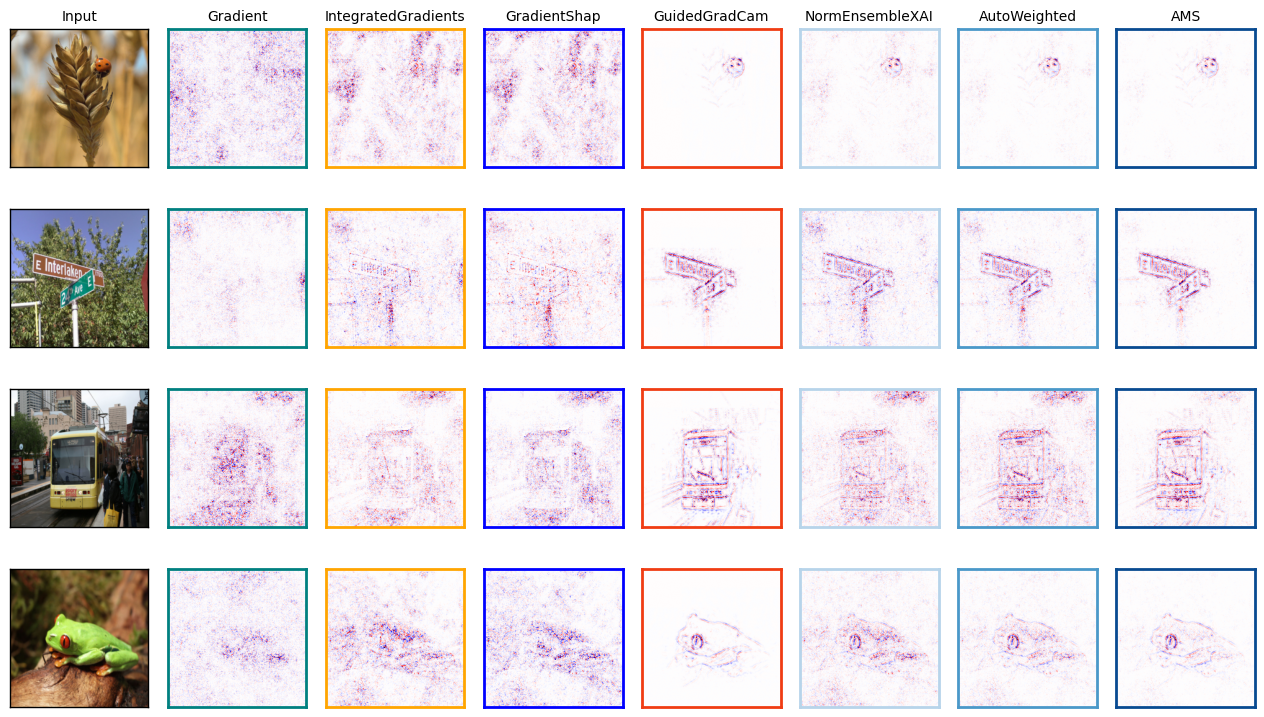

In [28]:
# Display multiple images with their explanations in a grid
include_titles = True
indices = [3, 8, 15, 18]
#indices = [i for i in range(x_batch.shape[0])] # Plot the whole batch
ncols = 1 + len(explanations)
nrows = len(indices)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.6, nrows*1.8))

for row, index in enumerate(indices):
    # Original image
    img = quantus.normalise_func.denormalise(
        x_batch[index].cpu(), 
        mean=np.array([0.485, 0.456, 0.406]), 
        std=np.array([0.229, 0.224, 0.225])
    )
    img = np.clip(img, 0, 1)
    axes[row, 0].imshow(np.moveaxis(img, 0, -1))
    class_id = y_batch[index].item()
    if include_titles and row == 0:  # Only add method titles to the top row
        axes[row, 0].set_title(f"Input", fontsize=10)
            
    # Hide ticks but keep frame for original image
    axes[row, 0].set_xticks([])
    axes[row, 0].set_yticks([])

    for spine in axes[row, 0].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Explanation methods
    for i in range(1, ncols):
        xai = methods_order[i-1]
        
        norm_exp = quantus.normalise_func.normalise_by_negative(explanations[xai][index].reshape(224, 224))
        axes[row, i].imshow(norm_exp, cmap="seismic", vmin=-1.0, vmax=1.0)
        
        if include_titles and row == 0: # Only add method titles to top row
            axes[row, i].set_title(methods_order[i-1], fontsize=10)
        
        # Hide ticks but keep frame for explanation images
        axes[row, i].set_xticks([])
        axes[row, i].set_yticks([])
        
        # Frame styling with colored borders
        axes[row, i].grid(False)
        for spine in axes[row, i].spines.values():
            spine.set_color(colours_order[i-1])
            spine.set_linewidth(2)

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# Save as pdf
#plt.savefig("figures/ex4_qualitative_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

### AutoWeighted and AMS obtained weights comparison
- each of these ensemble methods work differently to obtain the weights for the singular XAI methods (assigning importance)

In [32]:
for ens_name in ["AutoWeighted", "AMS"]:
    w = ensemble_weights[ens_name]
    df = pd.DataFrame(w, columns=BASE_METHODS)
    print(f"\n=== {ens_name} weights per sample ===")
    display(df.head())


=== AutoWeighted weights per sample ===


,Gradient,IntegratedGradients,GradientShap,GuidedGradCam
0,0.20166,0.222226,0.218357,0.357757
1,0.20166,0.222226,0.218357,0.357757
2,0.20166,0.222226,0.218357,0.357757
3,0.20166,0.222226,0.218357,0.357757
4,0.20166,0.222226,0.218357,0.357757



=== AMS weights per sample ===


,Gradient,IntegratedGradients,GradientShap,GuidedGradCam
0,0.138945,0.199336,0.149346,0.512373
1,0.142500,0.178669,0.102292,0.576539
2,0.061752,0.205641,0.182454,0.550152
3,0.099631,0.266181,0.141911,0.492278
4,0.094825,0.121034,0.082953,0.701188


---

## Computational Complexity
- **Benchmark** to analyze the computational cost of the ensemble methods (NormEnsembleXAI, AutoWeighted, AMS)
> **Beware:** Computationally heavy for large subsets!

In [56]:
# NOTE: This analysis section might be skipped (assesses comp. cost of the ensembles)
# ------> move to quantitative evaluation
# ------------------------------------------------------------------
# Benchmark
# N = 10, E = 4, K = 5, B = 1 – averaged over 30 runs
# N = number of samples (10) 
# E = number of base XAI methods (4: Gradient, IntegratedGradients, GradientShap, GuidedGradCam)
# K = number of metrics (5: Sparseness, PixelFlipping, LocalLipschitzEstimate, RelevanceMassAccuracy, RandomLogit)
# B = batch size (1)
# ------------------------------------------------------------------
import time
from tqdm.auto import tqdm

# ------------------------------------------------------------------#
# Select subset (e.g., N = 10)
# ------------------------------------------------------------------#
idx_sub = torch.arange(10) # first 10 samples
x_sub, y_sub, s_sub = x_batch[idx_sub], y_batch[idx_sub], s_batch[idx_sub]

# stack base maps: (N,E,C,H,W) on GPU
attrib_sub = torch.stack(
    [torch.from_numpy(explanations[m])[idx_sub].to(device)
     for m in BASE_METHODS], dim=1
)                                                       # (4,4,C,H,W)
N, E, C, H, W = attrib_sub.shape

# dataset-wide z-score (re-used by every ensemble)
var_ds, mean_ds = torch.var_mean(
    attrib_sub, dim=(0, 2, 3, 4), unbiased=False, keepdim=True)
attrib_norm = (attrib_sub - mean_ds) / torch.sqrt(var_ds + 1e-8)

In [57]:
# ------------------------------------------------------------------#
# Metric set  (K = 5) -> requirement for AutoWeighted and AMS
# ------------------------------------------------------------------#
metric_objs = [
    quantus.Sparseness(abs=True, normalise=True,  return_aggregate=False),  # ↑
    quantus.PixelFlipping(features_in_step=1024, abs=True, normalise=True,
                          perturb_baseline="mean", return_aggregate=False), # ↓
    quantus.LocalLipschitzEstimate(nr_samples=3, perturb_std=0.2,
                                   return_aggregate=False),                 # ↓
    quantus.RelevanceMassAccuracy(abs=True, normalise=False,
                                  return_aggregate=False),                  # ↑
    quantus.RandomLogit(num_classes=1000, abs=True, normalise=False,
                        return_aggregate=False),                            # ↓
]
metric_weights   = torch.tensor([.25, .25, .20, .15, .15], device=device)   # lambda vector
higher_is_better = torch.tensor([1, 0, 0, 1, 0],    device=device)          # 1 / 0

In [58]:
# ------------------------------------------------------------------#
# Utility helpers
# ------------------------------------------------------------------#
def torch_sync(): # alias
    torch.cuda.synchronize()

def wall(fn, *a, **kw): # GPU-aware timer
    torch_sync(); t0 = time.perf_counter()
    fn(*a, **kw)
    torch_sync(); return time.perf_counter() - t0

np_x     = x_sub.cpu().numpy()
np_y     = y_sub.cpu().numpy()
np_s     = s_sub.cpu().numpy()
maps_np  = attrib_sub.cpu().numpy().reshape(N*E, C, H, W) # flat version

In [59]:
# ------------------------------------------------------------------#
# Metric passes
# ------------------------------------------------------------------#
def _metric_pass(metric):
    """Run one metric over all NxE maps -> (N,E) torch tensor."""
    raw = metric(model        = model,
                 x_batch      = np.repeat(np_x, E, 0),
                 y_batch      = np.repeat(np_y, E, 0),
                 a_batch      = maps_np,
                 s_batch      = np.repeat(np_s, E, 0),
                 device       = device,
                 explain_func = _gradient_explainer,
                 explain_func_kwargs = dict(device=device))
    raw = np.asarray(raw)
    if raw.ndim > 1: # curves -> scalar
        raw = raw.mean(axis=-1)
    return torch.tensor(raw.reshape(N, E), device=device) # (N,E)

In [60]:
# ------------------------------------------------------------------#
# Stages to benchmark
# ------------------------------------------------------------------#
def fuse_norm():
    """Fuses attribution maps by taking their mean across ensemble dimension."""
    _ = attrib_norm.mean(dim=1) # (N,C,H,W)

def metrics_autoweighted():
    """Computes auto-weighted ensemble weights based on metric scores."""
    global w_aw
    scores = torch.stack([_metric_pass(m).mean(0) for m in metric_objs], -1) # (E,K)
    util   = (scores * metric_weights).sum(-1) # (E,)
    util.clamp_(min=1e-8)
    w_aw = util / util.sum()                   # (E,)

def fuse_aw():
    """Fuses attribution maps using auto-weighted ensemble weights."""
    w   = w_aw.view(1, E, 1, 1, 1)
    _ = (attrib_norm * w).sum(dim=1)

def metrics_ams():
    """Computes AMS (Adaptive Metric Scaling) ensemble weights using z-scores."""
    global w_ams
    all_m = torch.stack([_metric_pass(m) for m in metric_objs], -1) # (N,E,K)
    sign  = higher_is_better*2 - 1                                 # 1 -> +1, 0 -> -1
    directed = all_m * sign
    mu = directed.mean(1, keepdim=True);  sigma = directed.std(1, keepdim=True)+1e-8
    z  = (directed - mu) / sigma
    util = (z * metric_weights).sum(-1)                            # (N,E)
    w_ams = torch.softmax(util, dim=1)                             # (N,E)

def fuse_ams():
    """Fuses attribution maps using AMS ensemble weights."""
    w = w_ams.view(N, E, 1, 1, 1)
    _ = (attrib_norm * w).sum(dim=1)

In [62]:
# ------------------------------------------------------------------#
# Run the benchmark
# ------------------------------------------------------------------#
TIMES, N_REPEAT = [], 30

for _ in tqdm(range(N_REPEAT), desc="Benchmark runs"):
    TIMES.append(("NormEnsembleXAI", "fusion",  wall(fuse_norm)))

    TIMES.append(("AutoWeighted", "metrics",    wall(metrics_autoweighted)))
    TIMES.append(("AutoWeighted", "fusion",     wall(fuse_aw)))

    TIMES.append(("AMS",           "metrics",   wall(metrics_ams)))
    TIMES.append(("AMS",           "fusion",    wall(fuse_ams)))

    gc.collect(); torch.cuda.empty_cache()

Benchmark runs: 100%|██████████| 30/30 [13:48<00:00, 27.61s/it]


In [47]:
# ------------------------------------------------------------------#
# Summary table
# ------------------------------------------------------------------#
df_time = (pd.DataFrame(TIMES, columns=["Method", "Stage", "Time[s]"])
             .groupby(["Method", "Stage"])["Time[s]"]
             .agg(["mean", "std"])
             .reset_index()
             .rename(columns={"mean": "Mean [s]", "std": "Std [s]"}))

display(df_time.sort_values(["Method", "Stage"]).style.format({"Mean [s]":"{:.4f}",
                                                               "Std [s]":"{:.4f}"}))


,Method,Stage,Mean [s],Std [s]
0,AMS,fusion,0.0004,0.0004
1,AMS,metrics,28.7462,3.5931
2,AutoWeighted,fusion,0.0004,0.0005
3,AutoWeighted,metrics,28.3715,4.4692
4,NormEnsembleXAI,fusion,0.0012,0.0011


---

## Quantitative Evaluation via `Quantus`
- analyze individual XAI methods and ensembles via quantitative metrics

### Setup

In [37]:
# --- explicit evaluation order ------------------------------------------------
ENSEMBLES   = ["AMS", "AutoWeighted", "NormEnsembleXAI"] # "AMS2"
SINGLES     = ["GuidedGradCam", "Gradient", "IntegratedGradients", "GradientShap"]
ALL_METHODS = ENSEMBLES + SINGLES 

x_np = x_batch.cpu().numpy()
y_np = y_batch.cpu().numpy()
s_np = s_batch.cpu().numpy()

metrics = {
    "Robustness (↓)": quantus.LocalLipschitzEstimate(nr_samples=5, perturb_std=0.2, return_aggregate=True),
    "Complexity (↑)": quantus.Sparseness(abs=True, normalise=True, return_aggregate=True),
    "Faithfulness (↓)": quantus.PixelFlipping(features_in_step=1024, abs=True, normalise=True, perturb_baseline="mean", return_aggregate=True),
    "Localisation (↑)": quantus.RelevanceMassAccuracy(abs=True, normalise=False, return_aggregate=True),
    "Randomisation (↓)": quantus.RandomLogit(num_classes=1000, abs=True, normalise=False, return_aggregate=True),
}

# metrics that *require* explainer callback:
needs_explainer = {"Randomisation (↓)", "Robustness (↓)"}

# Captum-based adapter (chunked, GPU-safe)
chunk_map = {"Gradient": 16, "IntegratedGradients": 2, "GradientShap": 2, "GuidedGradCam": 2}
# GuidedGradCam needs conv layer
PER_METHOD_KW = {"GuidedGradCam": {"gc_layer": model.layer4[-1].conv3}}

# ---------------------------------------------------------------
# chunked Captum adapter 
# ---------------------------------------------------------------
def explain_chunked(model, inputs, targets, *, method, device, **user_kw):
    """Generates explanations in chunks to avoid memory issues, using Captum's XAI methods."""
    x = torch.as_tensor(inputs,  device=device, dtype=torch.float32)
    y = torch.as_tensor(targets, device=device, dtype=torch.long)

    x = x.clone().detach().requires_grad_(True)
    
    # base defaults
    if method != "Gradient":
        user_kw.setdefault("n_steps", 32)
        user_kw.setdefault("internal_batch_size", 1)

    # inject method-specific kwargs (e.g. gc_layer)
    kw = {**PER_METHOD_KW.get(method, {}), **user_kw}

    out, step = [], chunk_map[method]
    for i in range(0, len(x), step):
        attr = quantus.explain(model, x[i:i+step], y[i:i+step], method=method, device=device, **kw)
        out.append(attr.detach().cpu().numpy() if torch.is_tensor(attr) else attr)
        torch.cuda.empty_cache()
    return np.concatenate(out, axis=0)

In [411]:
# ---------- helpers ----------------------------------------------------------
def _stack_base(model, inputs, targets):
    """Return (N, M, C, H, W) numpy with M = 4 base explanations."""
    maps = [explain_chunked(model, inputs, targets,
                            method=b, device=device,
                            **PER_METHOD_KW.get(b, {}))
            for b in BASE_METHODS]
    return np.stack(maps, axis=1) # (N,M,C,H,W)

def _global_zscore(t):
    var = t.var(axis=(0,2,3,4), keepdims=True)
    mean = t.mean(axis=(0,2,3,4), keepdims=True)
    return (t - mean) / np.sqrt(var + 1e-8)


In [ ]:
# ---------- main explainer ---------------------------------------------------
def ensemble_explainer(model, inputs, targets, *, method, device, **kw_unused):
    """ Quantus-compatible explainer for NormEnsembleXAI | AutoWeighted | AMS
    """
    base = _stack_base(model, inputs, targets)   # (N,4,C,H,W)

    # 1 ─ NormEnsembleXAI  ....................................................
    if method == "NormEnsembleXAI":
        return _global_zscore(base).mean(axis=1) # (N,C,H,W)

    if method == "AutoWeighted":
        # AutoWeighted needs metrics calculated
        spars = quantus.Sparseness(abs=True, normalise=True,  return_aggregate=False)
        flip  = quantus.PixelFlipping(features_in_step=1024, abs=True, normalise=True, perturb_baseline="mean",return_aggregate=False)
        lips  = quantus.LocalLipschitzEstimate(nr_samples=5, perturb_std=0.2, return_aggregate=False)

        # make x/y as long as a_batch (N * 4)
        reps   = base.shape[1] # 4 base methods
        x_rep  = np.repeat(inputs,  reps, axis=0)
        y_rep  = np.repeat(np.asarray(targets).astype(np.int64), reps, axis=0)
        a_flat = base.reshape(-1, *base.shape[2:]) # (N*4,C,H,W)

        # run metrics and reshape back to (N,4)
        spars_v, flip_v, lips_v = [
            _metric_per_method(m, base, inputs, targets) # returns (N,4)
            for m in (spars, flip, lips)
        ]

        quality = spars_v - flip_v - lips_v              # ↑ good, ↓ bad
        w       = np.clip(quality, 1e-8, None)
        w       = w / w.sum(axis=1, keepdims=True)       # (N,4)
        w       = w[:, :, None, None, None]              # (N,4,1,1,1)

        return (w * _global_zscore(base)).sum(axis=1)    # (N,C,H,W)


    if method == "AMS":
        spars = quantus.Sparseness(abs=True, normalise=True, return_aggregate=False)
        flip  = quantus.PixelFlipping(features_in_step=1024, abs=True, normalise=True, perturb_baseline='mean', return_aggregate=False)
        lips  = quantus.LocalLipschitzEstimate(nr_samples=5, perturb_std=0.2, return_aggregate=False)

        raw   = [_metric_per_method(metr, base, inputs, targets) for metr in (spars, flip, lips)] # three (N,4)
        scores = np.stack(raw, axis=-1)                   # (N,4,3)

        # same lambda-vector and signs you used before
        w_metric = np.array([0.45, 0.30, 0.25])           # lambda
        sign     = np.array([-1, -1, +1])                 # maximise all ↑
        util     = (scores * sign) @ w_metric             # (N,4)
        tau      = 1.0 / (util.std() + 1e-8)
        w        = torch.softmax(torch.as_tensor(tau*util), dim=1).cpu().numpy()
        w        = w[:, :, None, None, None]              # (N,4,1,1,1)
        maps     = (w * _global_zscore(base)).sum(axis=1) # (N,C,H,W)
        return maps

    raise ValueError(f"Unknown ensemble '{method}'")

In [412]:
# ---------- helper for ensemble_explainer  --------------------------------
def _metric_per_method(metric, base, inputs, targets):
    """Helper function to compute metrics for each base method in ensemble."""
    reps   = base.shape[1]                          # 4
    x_rep  = np.repeat(inputs,  reps, axis=0)
    y_rep  = np.repeat(targets, reps, axis=0).astype(np.int64)
    a_flat = base.reshape(-1, *base.shape[2:])

    raw = metric(
        model=model,
        x_batch=x_rep,
        y_batch=y_rep,
        a_batch=a_flat,
        device=device,
        explain_func=_gradient_explainer,
        explain_func_kwargs=dict(device=device),
    )

    raw = np.asarray(raw)
    if raw.ndim > 1: # get scalar per attribution
        raw = raw.mean(axis=-1)

    return raw.reshape(base.shape[0], reps) # (N,4)

### Main Evaluation Loop
- obtain the metrics' scores for each of the XAI method (singular and ensembles)

In [413]:
# Some Quantus' metrics need to call the explainer repeatedly
needs_explainer = {"Randomisation (↓)", "Robustness (↓)"}

results = {}

for m in ALL_METHODS:
    print(f"Method {m} ...")
    results[m] = {}
    a_batch = explanations[m]
    for name, metric in metrics.items():
        print(f"-- {name}:")
        if name in needs_explainer:
            score = metric(
                model=model,
                x_batch=x_np,
                y_batch=y_np,
                s_batch=s_np,
                device=device,
                explain_func=(
                    explain_chunked if m in BASE_METHODS else ensemble_explainer
                ),
                explain_func_kwargs=dict(method=m, device=device)
            )
        else: # Attributions not needed to be recomputed
            score = metric(
                model=model,
                x_batch=x_np,
                y_batch=y_np,
                a_batch=a_batch,
                s_batch=s_np,
                device=device
            )
        print(f"---> score = {float(np.mean(score))}")
        results[m][name] = float(np.mean(score))

Method AMS ...
-- Robustness (↓):


c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


---> score = 0.09667865161660404
-- Complexity (↑):
---> score = 0.6449596857885962
-- Faithfulness (↓):
---> score = 0.0533250008874768
-- Localisation (↑):
---> score = 0.5100148916244507
-- Randomisation (↓):
---> score = 0.519614410955199
Method AutoWeighted ...
-- Robustness (↓):
---> score = 0.037877510507679665
-- Complexity (↑):
---> score = 0.5981746423765514
-- Faithfulness (↓):
---> score = 0.07119906820053017
-- Localisation (↑):
---> score = 0.4308064877986908
-- Randomisation (↓):
---> score = 0.5942891281148982
Method NormEnsembleXAI ...
-- Robustness (↓):
---> score = 0.06399286997750259
-- Complexity (↑):
---> score = 0.5861914843225969
-- Faithfulness (↓):
---> score = 0.07959605184369459
-- Localisation (↑):
---> score = 0.40871956944465637
-- Randomisation (↓):
---> score = 0.5450955737417883
Method GuidedGradCam ...
-- Robustness (↓):
---> score = 0.015838374655216463
-- Complexity (↑):
---> score = 0.8357440964374093
-- Faithfulness (↓):
---> score = 0.05299010281

### Preprocess the obtained results
- aggregate scores
- normalize 
- rank-based ordering

In [428]:
# Selected XAI method names
xai_methods = list(explanations.keys())

# Aggregate scores across metrics
results_agg = {method: {} for method in xai_methods}
for method in xai_methods:
    for metric in metrics:
        results_agg[method][metric] = np.mean(results[method][metric])

# Create dataframe and normalize values
df = pd.DataFrame.from_dict(results_agg).T.abs()

# if lower is better, use inverse ranking
lower_better = ["Robustness (↓)", "Faithfulness (↓)", "Randomisation (↓)"]
df_normalised = pd.DataFrame(index=df.index)

for metric in df.columns:
    if metric in lower_better:
        # invert: smaller raw -> bigger normalized
        df_normalised[metric] = df[metric].min() / df[metric]
    else:
        # higher raw -> bigger normalized
        df_normalised[metric] = df[metric] / df[metric].max()


# Calculate ranks
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Robustness (↓),Complexity (↑),Faithfulness (↓),Localisation (↑),Randomisation (↓)
Gradient,1.0,1.0,1.0,3.0,7.0
IntegratedGradients,3.0,5.0,3.0,2.0,3.0
GradientShap,2.0,4.0,2.0,1.0,4.0
GuidedGradCam,7.0,7.0,6.0,7.0,1.0
NormEnsembleXAI,5.0,2.0,4.0,4.0,5.0
AutoWeighted,6.0,3.0,5.0,5.0,2.0
AMS,4.0,6.0,7.0,6.0,6.0


## Radar Plot
- rank-based assessment based on the calculated qualitative metrics

In [429]:
import seaborn as sns
sns.set()

# Plotting configs
sns.set_style("whitegrid")
plt.rcParams['ytick.labelleft'] = True; plt.rcParams['xtick.labelbottom'] = True

In [ ]:
# Convert float values to integers
df_normalised_rank = df_normalised_rank.astype(int)
# assume df is your DataFrame
cols = df_normalised_rank.columns.tolist()

# move first column to end
df_normalised_rank = df_normalised_rank[cols[1:] + [cols[0]]]

# strip everything in parentheses (including arrows)
df_normalised_rank.columns = [col.split(' (')[0] for col in df_normalised_rank.columns]

In [ ]:
def _rank_to_radius(df_rank: pd.DataFrame, radius_max: float = 0.8) -> pd.DataFrame:
    """Mapping rank -> radius : linear, centre stays at zero."""
    max_rank = df_rank.to_numpy().max()          # e.g. 3
    step = radius_max / max_rank                 # distance per rank level
    return df_rank * step


def plot_radar_rank(
        df_rank: pd.DataFrame,
        title: str = "Rank-based radar plot", 
        ordered_colors: list[str] | None = None,
        figsize: tuple[int, int] = (10, 8),
        radius_max: float = 0.8,
        save_path: str | None = None,
):
    """Creates a rank-based radar plot of different XAI methods across multiple metrics. """
    # -- radial data -------------------------------------------------------------
    inner_max = radius_max * (1 - 0.05)
    df_radial = _rank_to_radius(df_rank, inner_max)
    # british -> american
    df_rank.rename(columns={"Localisation": "Localization", "Randomisation": "Randomization"}, inplace=True)
    
    # -- geometry ----------------------------------------------------------------
    labels = list(df_rank.columns)
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1] # close polygon

    # NOTE: singular and ensemble colors are defined globally
    colors = {**singular_colors, **ensemble_colors}

    # -- plot --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    # -- outer-rank pentagon -----------------------------------------------------
    outer = [radius_max] * N + [radius_max] # one radius per axis
    ax.fill(angles, outer, alpha=0.15, color="gray", zorder=0)

    # Plot singular methods' results
    singular_methods = ["Gradient", "IntegratedGradients", "GradientShap", "GuidedGradCam"]
    ax.set_theta_zero_location('N')
    for method in df_radial.index:
        c = colors[method]
        is_singular = method in singular_methods
        lw = 2 if is_singular else 5
        alpha = 0.25 if is_singular else 1
        vals = df_radial.loc[method].tolist() + df_radial.loc[method].tolist()[:1]
        ax.plot(angles, vals, linewidth=lw, color=c, label=method, alpha=alpha)

    # -- axis labels + tick alignment --------------------------------------------
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=14)
    ax.tick_params(axis='x')

    # -- radial ticks: 0 (center) ... max_rank (outer) ---------------------------
    max_rank = df_rank.to_numpy().max()
    yticks = np.linspace(0, radius_max- 0.05, max_rank + 1) # include 0
    yticklabels = [str(r) for r in range(0, max_rank + 1)]  # '0','1',...,'3'
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim(0, radius_max)

    for lab in ax.get_xticklabels():
        lab.set_fontsize(16)
        if lab.get_text() in ("Faithfulness", "Robustness"):
            theta, r = lab.get_position()         # (angle [rad], radius)
            lab.set_position((theta, r - 0.1))    # push 0.08 'upwards'
            lab.set_verticalalignment('center')

    ax.grid(True, linestyle='-', alpha=0.8, color="white")
    ax.spines['polar'].set_visible(False)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), borderpad=1, fontsize=12)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    if save_path:
        fig.savefig(save_path, format='pdf', bbox_inches="tight", dpi=300)

    return fig, ax

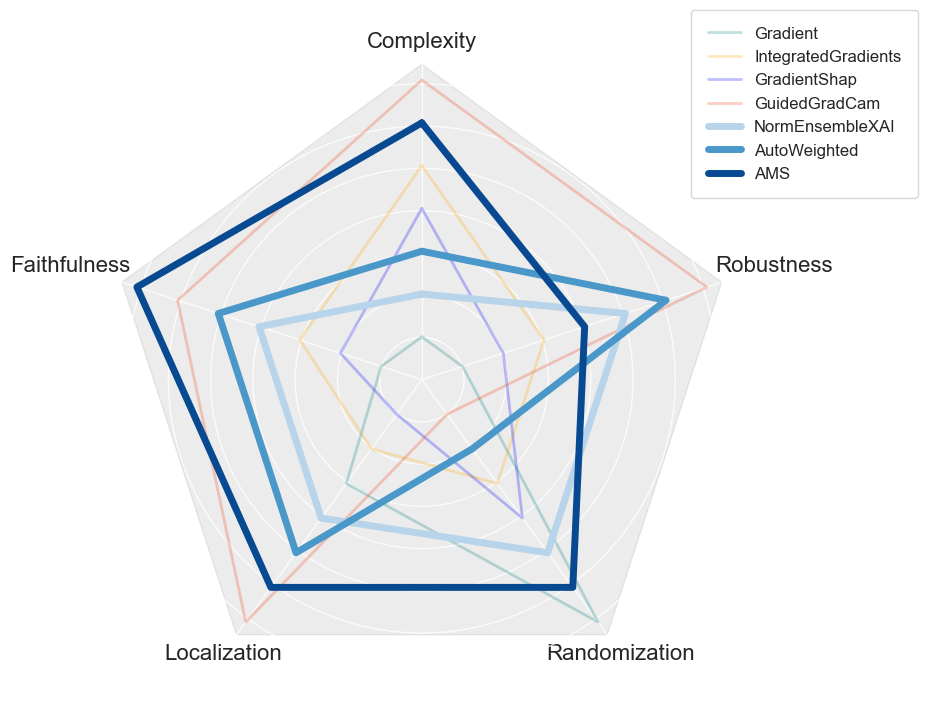

In [436]:
fig, ax = plot_radar_rank(df_normalised_rank)#, save_path="figures/ex4_imagenet_radar_ranked_all.pdf")
plt.show()